# Reinforcement learning

## Double Q-Learning 
* Problems to consider: Cliff walking
* Initialize QA and QB with zeros
* Randomly Update QA and QB 

#### If updating QA

 $ A*=  \max_ {A} Q{A}(S′,a) $    Where A* is the action with max Q value in QA Table
 Updating QA: $QA(S,A) := Q(S,A) + \alpha \Big [ R(S') + \gamma Q{_B}(S′,A*)  − QA(S, A) \Big ]$

#### If updating QB

 $ B*=  \max_ {A} Q{B}(S′,a) $    Where B* is the action with max Q value in QB Table
 Updating QB: $QB(S,A) := QB(S,A) + \alpha \Big [ R(S') + \gamma Q{_A}(S′,A*)  − QB(S, A) \Big ]$



#### Installation note
Numpy and matplotlib needs to be installed for this notebook to run. Additionally, I use Python built in itertools to create hyperparameter combinations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

#### Helper functions for the implemantion of Double Q-learning

In [2]:
def update_Q(QA,QB, S, A, R, S_prime, A_prime, alpha, gamma): 
    if S_prime is None: # S_prime is a terminal state
        QA[S,A] = QA[S,A] + alpha * (R - QA[S,A])
        QB[S,A] = QB[S,A] + alpha * (R - QB[S,A])
    elif A_prime is None:  # Updating QA or  QB on random bases
        if np.random.uniform() < 0.5:                             
            A_star=np.argmax(QA[S_prime,])
            #Update QA with the value of QB for S'
            QA[S,A] = QA[S,A] + alpha * (R + gamma * QB[S_prime,A_star] - QA[S,A])  
        else:                                                     
            #maximal valued action in S' according to QB                 
            B_star=np.argmax(QB[S_prime,])                                         
            #Update QB with the value of QA for S'               
            QB[S,A] = QB[S,A] + alpha * (R + gamma * QA[S_prime,B_star] - QB[S,A]) 
    return QA,QB

In the above update_Q function, we can see that each Q function is updated with a value from the other Q funtion for the
next state. Furthermore, both QA and QB learn from separate sets of experiences, but for selecting an action to be performed, one can use both value functions.

In [3]:
def epsilon_greedy_take_action(QA,QB ,S, epsilon):
    max_actions = QA.shape[1] #QB.shape[1] can also be used
    if np.random.random() < epsilon:  
        # random action
        return np.random.choice(max_actions, size=1)
    else:
        Q_average=(QA+QB)/2 #Taking average of QA and QB 
        # greedy action
        return np.argmax(Q_average[S,])     
    
    
def agent_environment_interaction(environment_func, optional_args, QA,QB, S, A, epsilon=0.1, alpha=0.5, gamma=0.9):
    if A is None:
        # Return a Greedy action based on Epsilon Greedy Function
        A = epsilon_greedy_take_action(QA,QB, S, epsilon)  
        #Take step based on action returned 
    R, S_prime = environment_func(S, A, optional_args=optional_args) 
    A_prime = None
    #Update and Return QA and QB
    QA,QB = update_Q(QA,QB, S, A, R, S_prime, A_prime, alpha, gamma) 
    return QA,QB, S_prime, A_prime,R

In [4]:
def cliff_environment(S, A, optional_args=None, verbose=False):    
    if optional_args is not None:    
        cliff_is_terminal_state = optional_args["cliff_is_terminal_state"]
        increased_goal_reward = optional_args["increased_goal_reward"]
        epsilon = optional_args["epsilon"]
    else:
        cliff_is_terminal_state = True
        increased_goal_reward = True
        epsilon = 0
    
    if verbose: print("S =", S, "A =", A)
    row = int(S / 12)
    col = S % 12
    if verbose: print("row =", row, "col =", col)
        
    if A == 0: # north
        row -= 1
    elif A == 1: # east
        col += 1
    elif A == 2: # south
        row += 1
    elif A == 3: # west
        col -= 1
    if np.random.random() < epsilon:
        row += 1 # down-wind        
    R = -1
    if row == 3 and col >= 1 and col <= 10: # falling from the cliff
        if cliff_is_terminal_state:
            S_prime = None # terminal state
        else:
            S_prime = 36 # back to start
        R = -100
    elif row == 3 and col == 11: # goal
        S_prime = None # terminal state
        if increased_goal_reward:
            R = 0
    elif row < 0 or col < 0 or row >= 4 or col >= 12:
        S_prime = S # stay where you are
    else:
        S_prime = row * 12 + col
    if verbose: print("new row =", row, "new col =", col, "S_prime =", S_prime, "R =", R)
    return R, S_prime

def cliff_environment_print_Q(Q):    
    for row in range(4):
        print("-------------------------\n", end="")
        for A in range(4):
            print("|", end="")
            for col in range(12):
                S = row * 12 + col
                if S >= 37 and S < 47:
                    print("**********|", end="") # cliff
                elif S == 47:
                    print("G|", end="") # goal
                elif A == 0:
                    print("N: {:07.2f}|".format(np.round(Q[S,A], 2)), end="")
                elif A == 1:
                    print("E: {:07.2f}|".format(np.round(Q[S,A], 2)), end="")
                elif A == 2:
                    print("S: {:07.2f}|".format(np.round(Q[S,A], 2)), end="")
                elif A == 3:
                    print("W: {:07.2f}|".format(np.round(Q[S,A], 2)), end="")
            print("\n", end="")
    print("-------------------------\n", end="")
    
def cliff_environment_policy(Q):    
    for row in range(4):
        print("-------------------------\n|", end="")
        for col in range(12):
            S = row * 12 + col
            if S >= 37 and S < 47:
                print("*|", end="") # cliff
            elif S == 47:
                print("G|", end="") # goal
            else:
                A = np.argmax(np.round(Q[S,], 2))
                if A == 0:
                    print("N|", end="")
                elif A == 1:
                    print("E|", end="")
                elif A == 2:
                    print("S|", end="")
                elif A == 3:
                    print("W|", end="")
        print("\n", end="")
    print("-------------------------\n", end="")

In [5]:
# go east from start state (36)
cliff_environment(36, 1, verbose=True) 

S = 36 A = 1
row = 3 col = 0
new row = 3 new col = 1 S_prime = None R = -100


(-100, None)

In [6]:
def cliff_environment_loop(episodes, epsilon, alpha, gamma, optional_args=None):
    max_states = 12 * 4
    max_actions = 4   # north, east, south, west
    QA = np.zeros((max_states, max_actions)) # Initialize QA
    QB = np.zeros((max_states, max_actions)) # Initialize QA
    
    total_steps_per_episode=[]   # steps to reach the goal or fall into cliff region in each episode
    total_reward_per_episode=[]  # Total Reward at end of each episode
    
    for _ in range(episodes):
        S = 36   # start state
        A = None
        steps = 0 
        total_reward = 0                         
        while S is not None: 
            QA, QB, S, A, reward = agent_environment_interaction(cliff_environment, optional_args, QA,QB,
                                                               S, A, epsilon=epsilon, alpha=alpha,
                                                               gamma=gamma
                                                              )
            if steps==0:
                total_reward = reward  # Initially Total reward is equal to the reward earned on first step 
            else:
                total_reward += reward # After first step the total reward is accumulated 
            # Number of steps taken    
            steps = steps + 1 
        # Total number of steps taken in each Episode before falling into cliff or Reaching goal 
        total_steps_per_episode.append(steps)
        # Total reward earned in a loop
        total_reward_per_episode.append(total_reward)  
    return QA, QB, total_steps_per_episode, total_reward_per_episode

In [7]:
print("Double Q-Learning")

epsilon = 0.1 
alpha = 0.5
gamma = 0.9

episodes_steps=[]    # To calculate Number of steps 
episodes_rewards=[]  # To calculate reward

for T in [1000, 10000, 20000]:
    np.random.seed(777)
    QA,QB,steps,rewards= cliff_environment_loop(T, epsilon, alpha, gamma) #Double Q-learning after T episodes
    episodes_steps.append(steps) # Total Steps in  T episode 
    episodes_rewards.append(rewards) # Total Reward T episodes
    Q_average=(QA+QB)/2
    print("Policy after", T, "episodes:")
    cliff_environment_policy(Q_average)
    print("Q values:")
    cliff_environment_print_Q(Q_average)

Double Q-Learning
Policy after 1000 episodes:
-------------------------
|N|S|S|E|E|E|S|S|W|N|S|S|
-------------------------
|S|E|E|S|S|E|E|E|S|E|E|S|
-------------------------
|E|E|E|E|E|E|E|E|E|E|E|S|
-------------------------
|N|*|*|*|*|*|*|*|*|*|*|G|
-------------------------
Q values:
-------------------------
|N: -008.06|N: -008.11|N: -007.62|N: -007.73|N: -007.25|N: -007.18|N: -006.31|N: -005.70|N: -005.36|N: -004.36|N: -003.93|N: -002.79|
|E: -008.16|E: -008.10|E: -007.69|E: -007.63|E: -007.22|E: -006.97|E: -006.23|E: -005.70|E: -005.25|E: -004.36|E: -003.94|E: -002.95|
|S: -008.23|S: -007.74|S: -007.60|S: -007.64|S: -007.29|S: -006.99|S: -006.15|S: -005.65|S: -005.30|S: -004.45|S: -003.70|S: -002.57|
|W: -008.17|W: -008.13|W: -007.98|W: -007.74|W: -007.47|W: -007.17|W: -006.37|W: -005.94|W: -005.19|W: -004.39|W: -003.93|W: -002.79|
-------------------------
|N: -008.35|N: -008.16|N: -007.91|N: -007.66|N: -007.43|N: -007.05|N: -006.80|N: -005.74|N: -005.50|N: -004.11|N: -002.79|

In the above double-Q learning algorithm, the agent uses two separate Q-value functions, QA and QB, to estimate the value of different actions in different states. The cliff environment policy for QA and QB dictates how the agent should select actions in each state to avoid falling off the cliff while achieving a high total reward.

The agent selects one of the Q-value functions at each step and uses it to select the action with the highest estimated value. We can see it in the output above if we consider policy after 1000 episodes just for demonstration purpose. When the agent is in starting state it took action: N because this action has the maximum estimated value -007.18 to avoid falling into cliff and having maximum reward. Then the agent updates the other Q-Value function with the observed reward and the estimated value of the next state.For the next state, agent choses E having maximum estimated value of -006.86 among others and so on till reach the goal.

By using two separate Q-value functions, the double-Q learning algorithm quickly converges to an optimal policy and reduces the problem of overestimation that can occur with traditional Q-learning.


# Analysis of Results

Let's look at the relevant plots to understand the results of the training process.

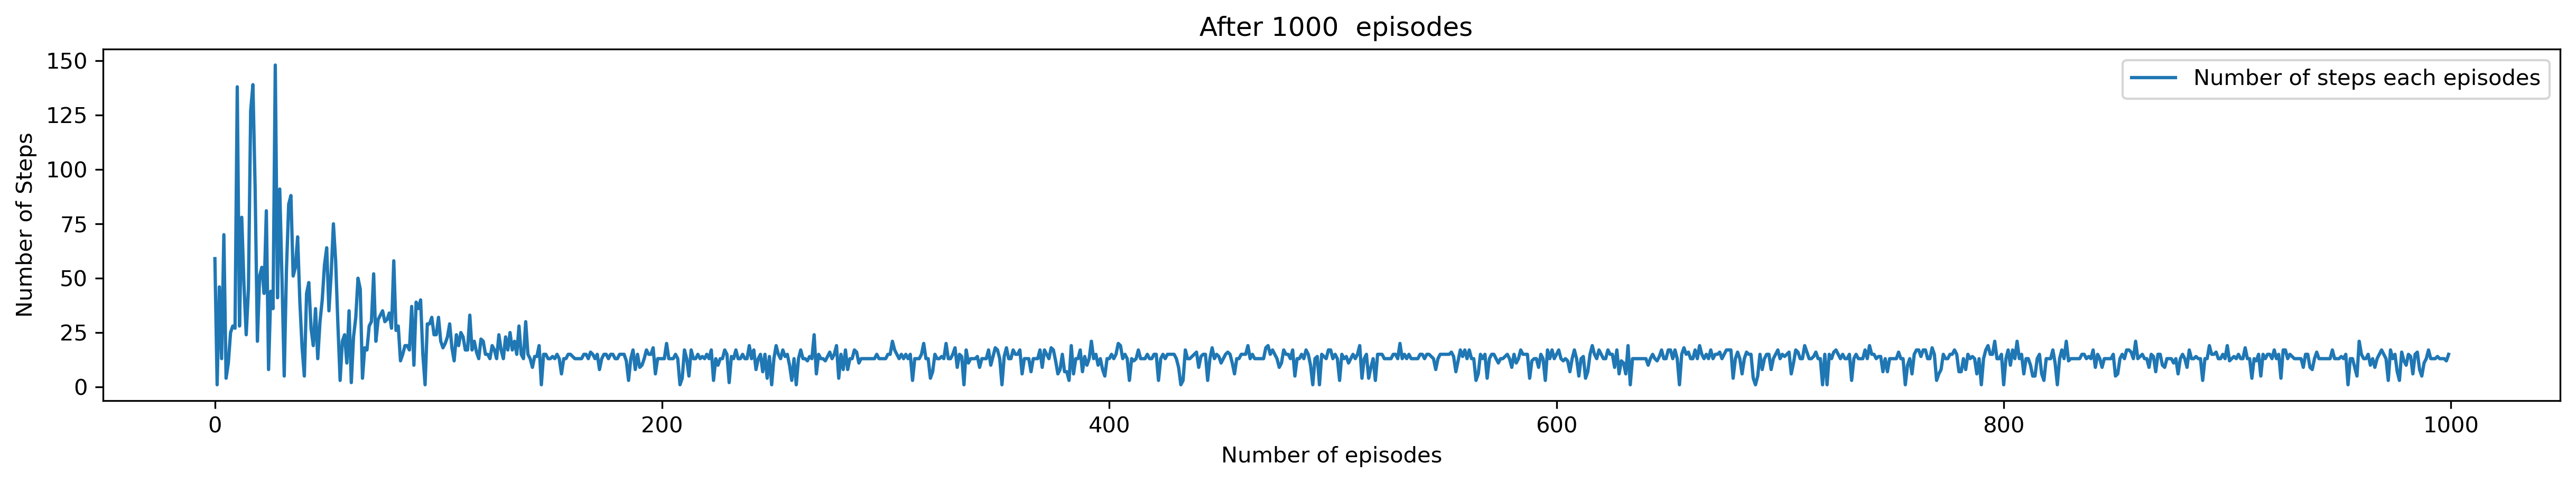

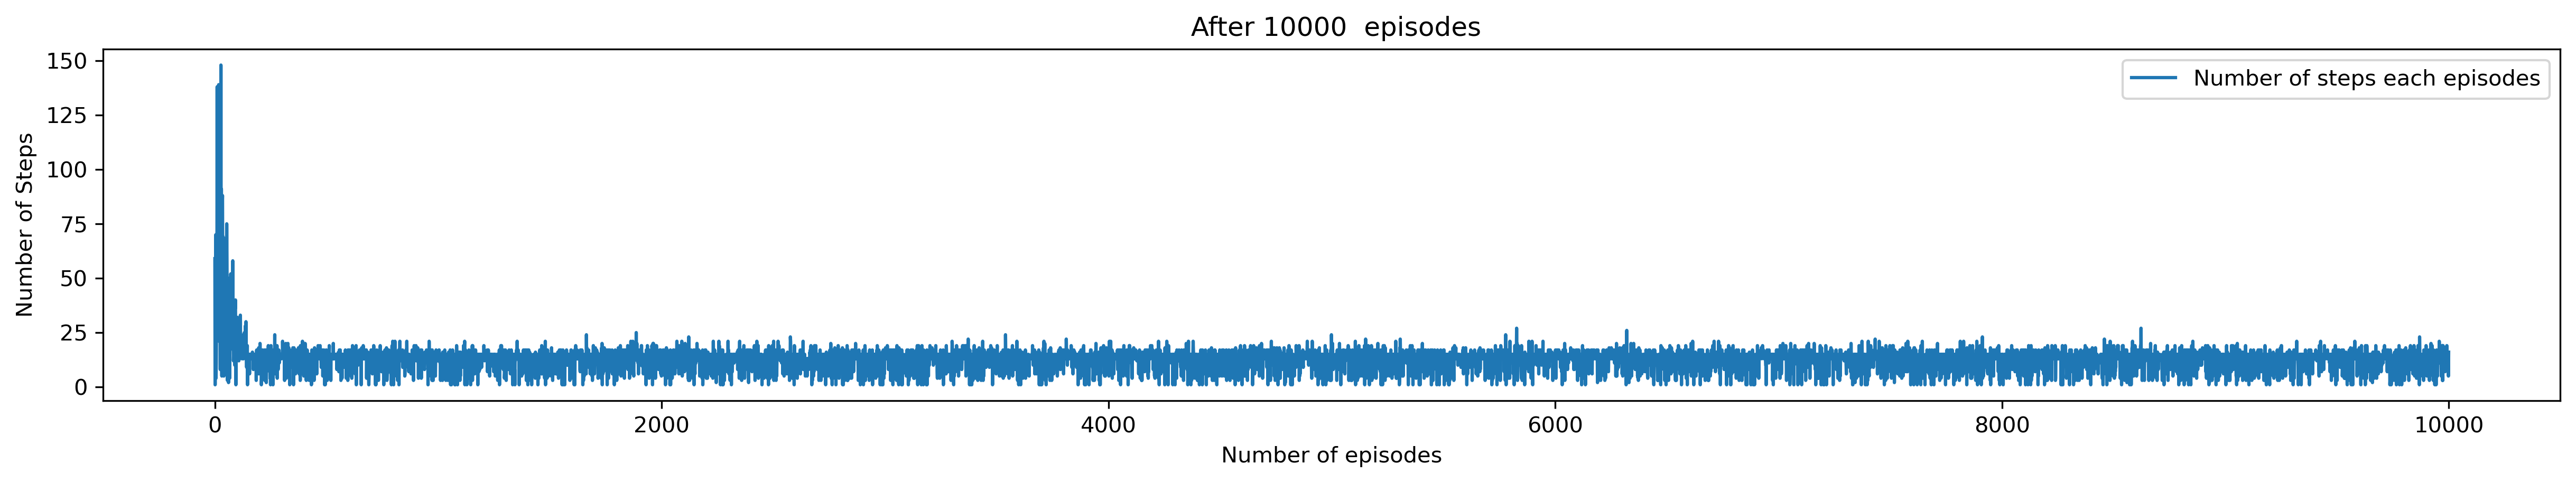

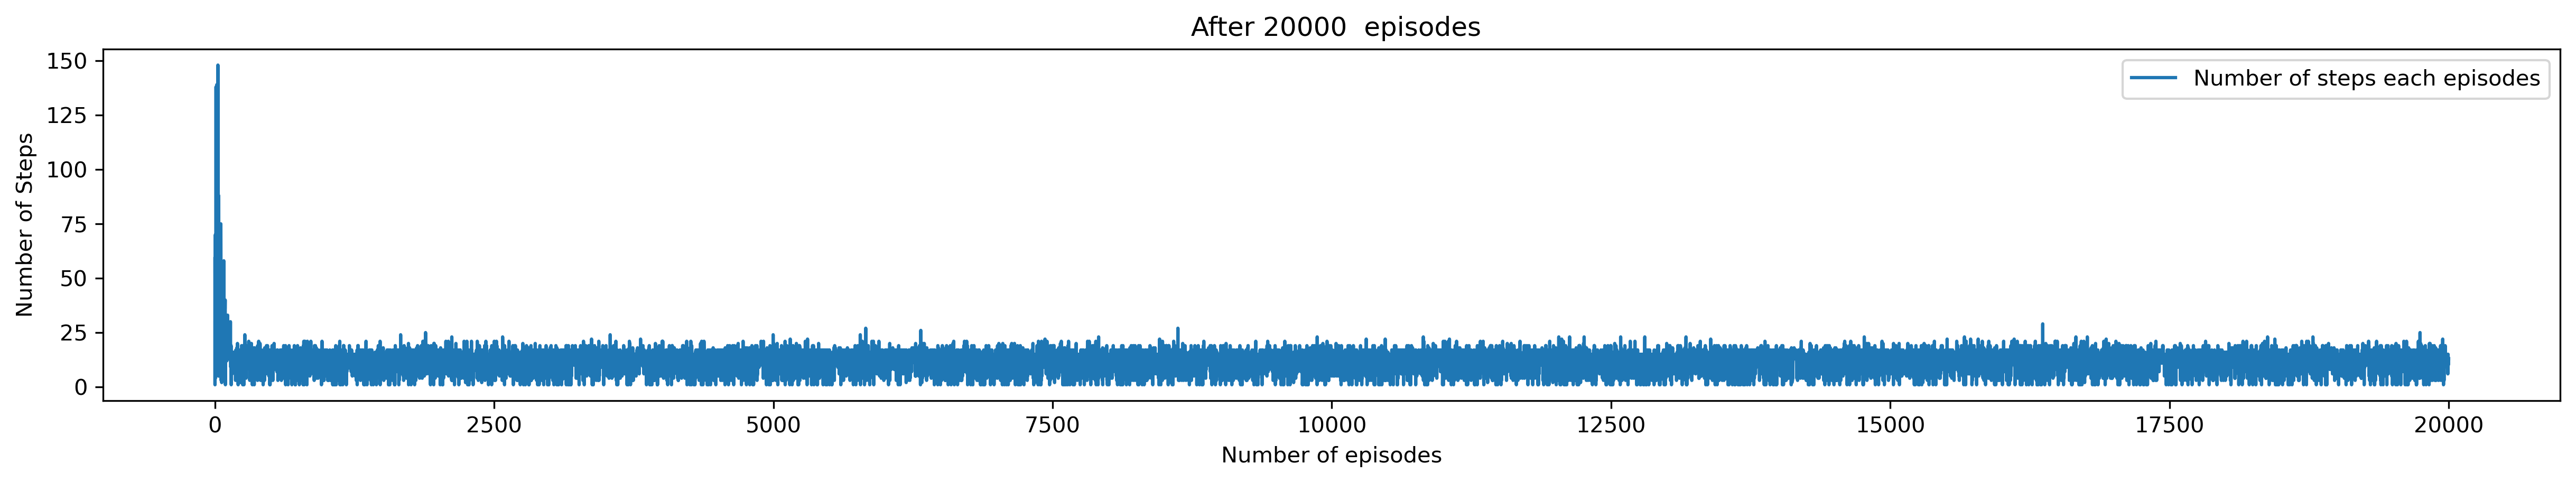

In [8]:
#To visualize total number of steps taken per episodes 
for i , j in enumerate(episodes_steps):
    plt.figure(figsize=( 20,10), dpi=300)
    plt.subplot(3, 1, i+1)
    plt.title(" After " +str(len(j))+ "  episodes")
    plt.xlabel("Number of episodes")
    plt.ylabel("Number of Steps")
    plt.plot(j,label="Number of steps each episodes")
    plt.legend(loc="upper right")
    plt.show()

In the graphs above, we have analysed 1000,10000 and 20000 episodes that the agent completed to reach the final goal or fall into the cliff area. We can see that at the beginning, the agent was new to the environment and took a large number of steps per episode, which resulted in a lower reward (Adding negative rewards results lower value). However, after a few episodes, the agent started taking fewer steps to reach the terminal state, and the behaviour of the graph became stable compared to the initial phase. It means, after exploring the environment, the agent takes less steps and follows the more optimal path to reach the Goal. 

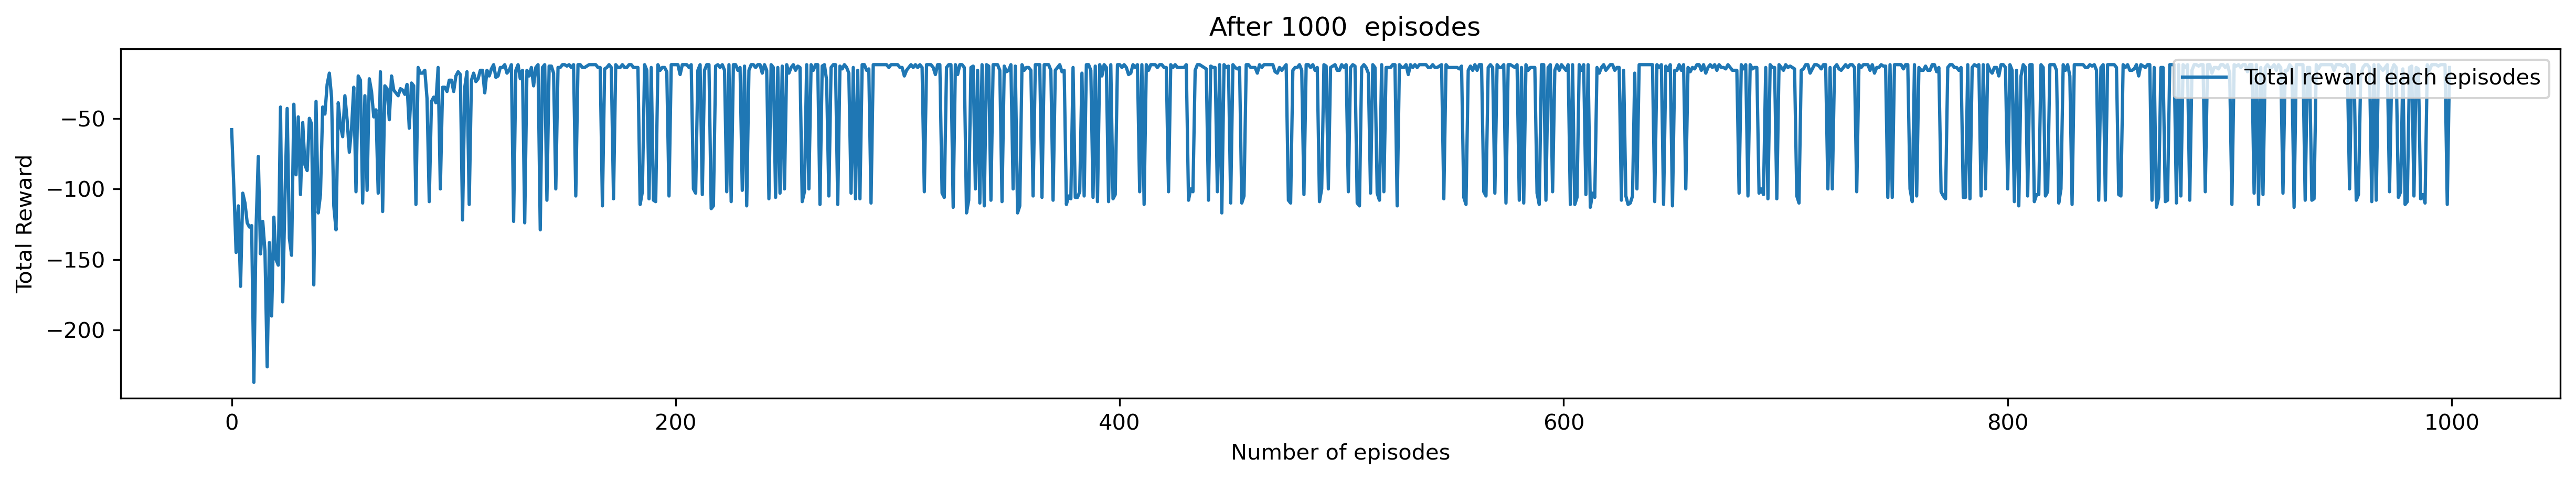

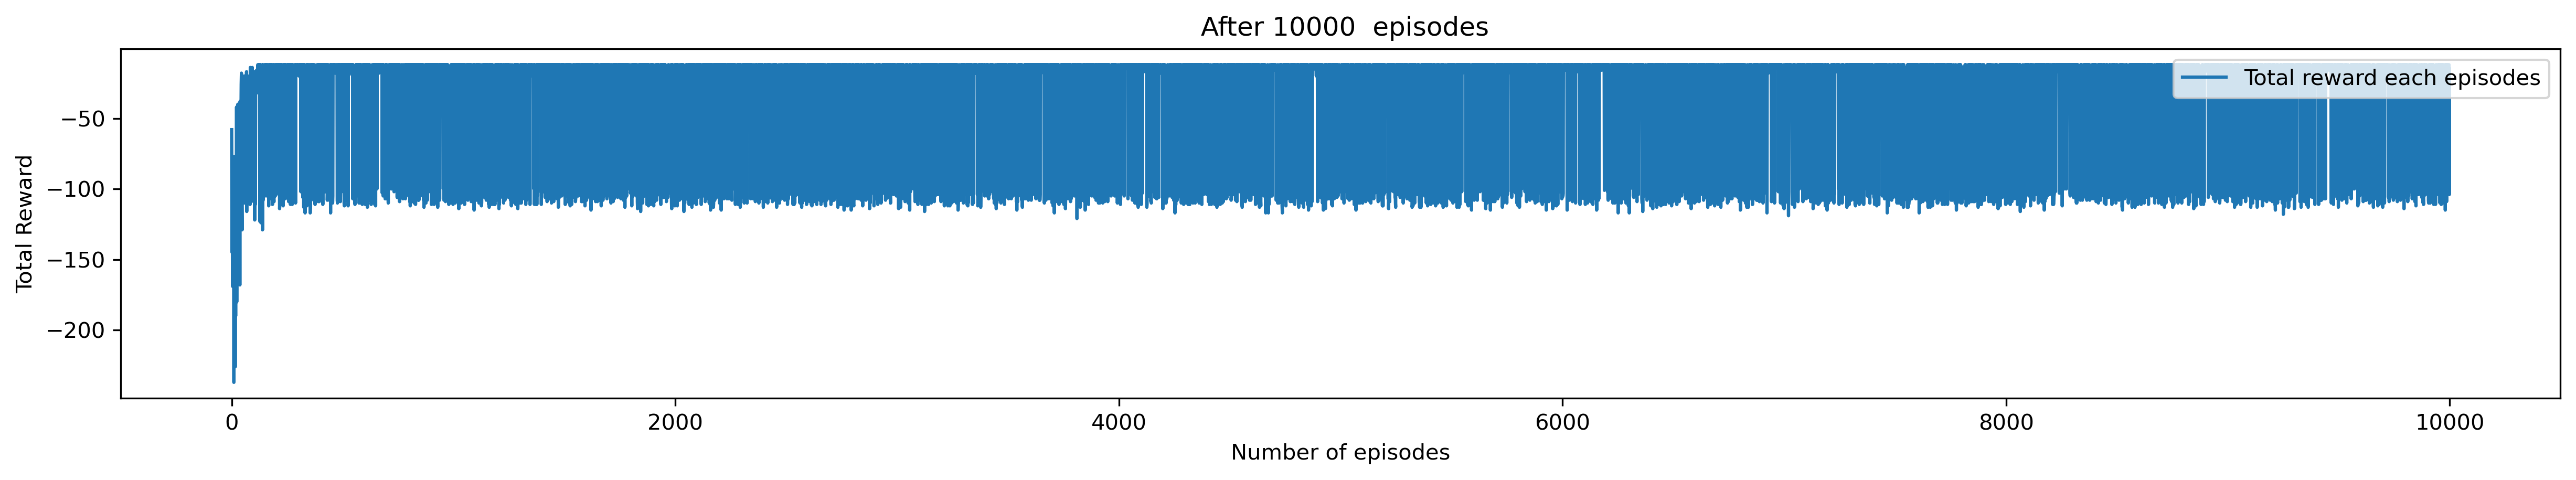

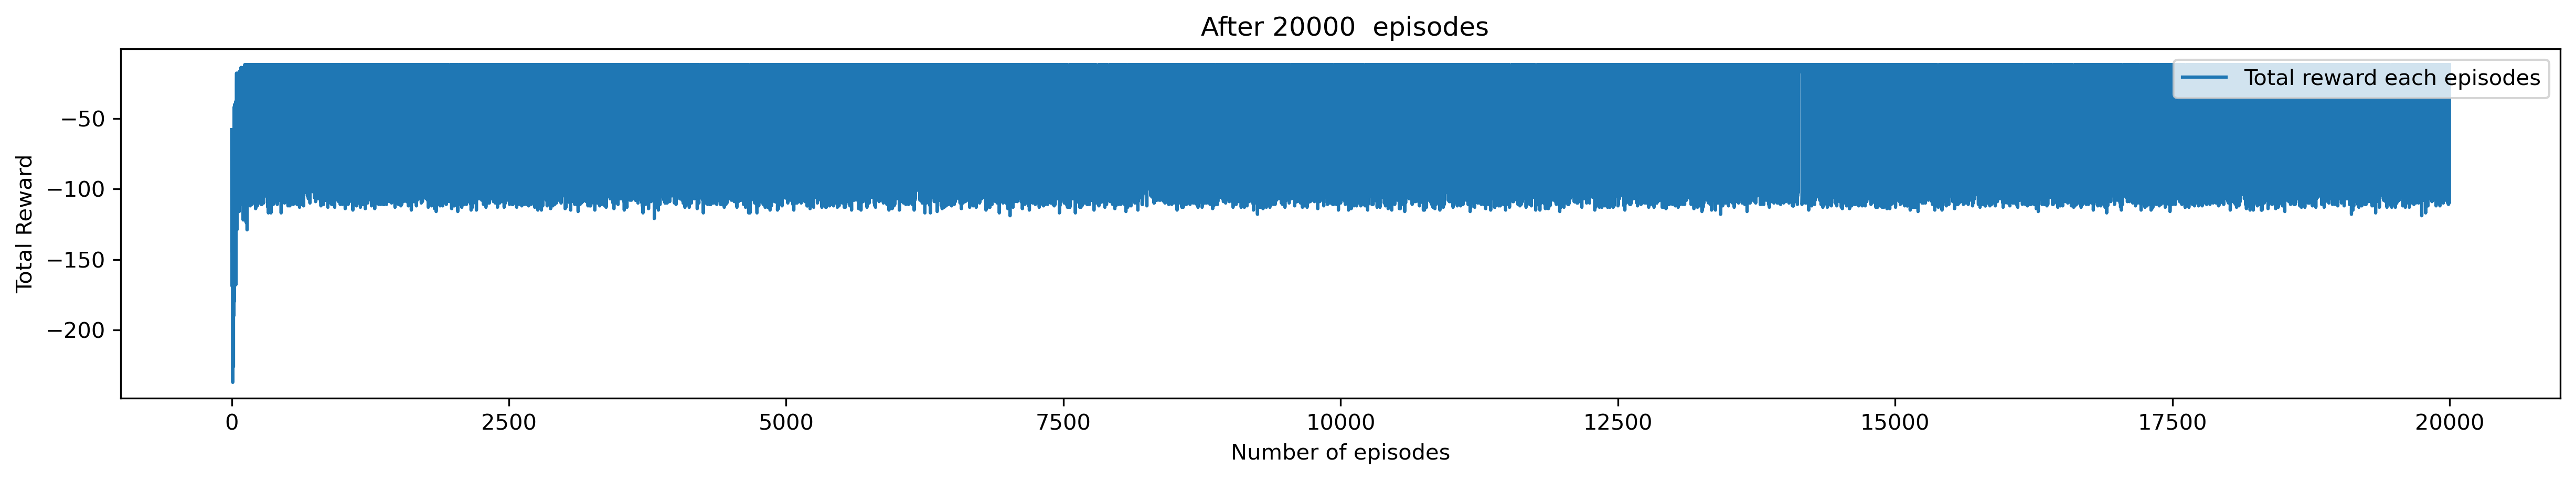

In [9]:
# To visualize Total rewards earned per episodes 
for i , j in enumerate(episodes_rewards):
    plt.figure(figsize=( 20,10), dpi=300)
    plt.subplot(3, 1, i+1)
    plt.title(" After " +str(len(j))+ "  episodes")
    plt.xlabel("Number of episodes")
    plt.ylabel("Total Reward")
    plt.plot(j,label="Total reward each episodes")
    plt.legend(loc="upper right")
    plt.show()

Since we have negative values for the reward (R=-1) and the penalty (R=-100), we can see in the above graphs for different episodes that the reward achieved by the agent at the end of each episode was lower in the beginning. This is because the agent takes more steps in the earlier episodes and accumulates more negative rewards at the end of each step to reach the terminal state. In the initial stage, the agent did not follow the best path to reach the goal, resulting in lower rewards at the end of that particular episode.
On the other hand, we can also see that over time, the agent started to follow optimal paths to reach the final state, and the reward per episode became high. With the increase in number of episodes, we can see a significant improvement in the agent's performance and the graph becomes approximately flat.

Fewer steps to reach the goal are in direct proportion to the maximum reward. 

# Hyper Parameter Tuning

In the following cell we perform hyperparameter tunning for Epsilon, alpha, and Gamma to come up with the best set of values. We will see the affect of changing these values on the average reward earned. 

In [10]:
# Evaluating average reward over a fixed number of episodes (T=1000) to find the best hyperparameters

# Declare hyperparameters
epsilon_values = [ 0.1, 0.4, 0.7] # Different values for epsilon to be tuned 
alpha_values = [0.2, 0.5, 0.8]   # Different values for Alpha to be tuned
gamma_values = [0.5, 0.9, 1.5]   # Different values for gamma to be tuned
T = 1000

# Create all possible combinations of hyperparameters
hparameters_combinations = list(itertools.product(*[epsilon_values, alpha_values, gamma_values]))

print(f"Average reward after {T} Episodes:")
for idx, hparameters_combination in enumerate(hparameters_combinations):
    np.random.seed(777)
    # Unzip the tuple to individual parameters
    epsilon, alpha, gamma = hparameters_combination
    QA, QB, steps, rewards= cliff_environment_loop(T, epsilon, alpha, gamma) 
    # Printing average reward for different combinations of epsilon and alpha
    average_reward = sum(rewards)/len(rewards)
    print(f'Hypermeter combination: epsilon: {epsilon}, alpha:{alpha}',
          f'gamma: {gamma}, Average reward: {average_reward}')

Average reward after 1000 Episodes:
Hypermeter combination: epsilon: 0.1, alpha:0.2 gamma: 0.5, Average reward: -49.93
Hypermeter combination: epsilon: 0.1, alpha:0.2 gamma: 0.9, Average reward: -46.201
Hypermeter combination: epsilon: 0.1, alpha:0.2 gamma: 1.5, Average reward: -97.629
Hypermeter combination: epsilon: 0.1, alpha:0.5 gamma: 0.5, Average reward: -39.976
Hypermeter combination: epsilon: 0.1, alpha:0.5 gamma: 0.9, Average reward: -38.199
Hypermeter combination: epsilon: 0.1, alpha:0.5 gamma: 1.5, Average reward: -100.181
Hypermeter combination: epsilon: 0.1, alpha:0.8 gamma: 0.5, Average reward: -37.389
Hypermeter combination: epsilon: 0.1, alpha:0.8 gamma: 0.9, Average reward: -37.258
Hypermeter combination: epsilon: 0.1, alpha:0.8 gamma: 1.5, Average reward: -100.493
Hypermeter combination: epsilon: 0.4, alpha:0.2 gamma: 0.5, Average reward: -96.187
Hypermeter combination: epsilon: 0.4, alpha:0.2 gamma: 0.9, Average reward: -92.771
Hypermeter combination: epsilon: 0.4, a

From the above evaluation of our agent for different combinations of our hyper-parameters with the number of episodes constant, we see that the best set of hyperparameters was epsilon= 0.1 and aplha= 0.8,  and gamma= 0.9, giving the highest average reward of -37.258. 

In addition, we can also evaluate the convergence rate to determine the efficiency of the Double-Q learning algorithm, and we can also track the number of penalties (R=-100 by falling into a cliff) depending on the combination of hyperparameter values, as this can also be a crucial factor.

# References

[1]. Hado van Hasselt. Double Q-Learning

[2]. Richard S. Sutton and Andrew G.Barto. An Introduction to Reinforcement Learning. Chapter 6. Temporal-Difference Learning, page 119-140 

[3]. Prof. Dr. Stefan Faußer. Lecture on Big Data and AI
